In [1]:
import numpy as np
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
import scipy.io as scio
import scipy
import skimage as sk
from skimage import color
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LeakyReLU
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import h5py
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Flatten, Reshape, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Input
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1970921333706761249
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7680170394
locality {
  bus_id: 1
}
incarnation: 12994768042309996166
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


# Load Datasets

Loads the SVHN and MNIST datasets. We'll be building a binary classifier that classifies an image as part of the MNIST dataset or SVHN dataset. 

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_train_X = mnist.train.images
mnist_test_X = mnist.test.images
mnist_train_y = mnist.train.labels
mnist_test_y = mnist.test.labels

In [5]:
svhn_train = scio.loadmat('svhn_train.mat')
svhn_test = scio.loadmat('svhn_test.mat')

In [6]:
svhn_train_X = svhn_train['X']
svhn_train_y = svhn_train['y']
svhn_test_X = svhn_test['X']
svhn_test_y = svhn_test['y']
encoder = OneHotEncoder()
svhn_train_y = encoder.fit_transform(svhn_train_y).todense()
svhn_test_y = encoder.fit_transform(svhn_test_y).todense()

# Preprocessing

In [7]:
def resize_images(imgs):
    return np.array([sk.img_as_float(scipy.misc.imresize(img.reshape(28, 28), (32, 32))) for img in imgs])

In [8]:
svhn_train_X = np.array([sk.img_as_float(scipy.misc.imresize(svhn_train_X[:, :, :, i], (32, 32, 3))) for i in range(svhn_train_X.shape[-1])])
svhn_test_X = np.array([sk.img_as_float(scipy.misc.imresize(svhn_test_X[:, :, :, i], (32, 32, 3))) for i in range(svhn_test_X.shape[-1])])

In [9]:
mnist_train_X = resize_images(mnist_train_X).reshape(mnist_train_X.shape[0], 32, 32, 1)
mnist_test_X = resize_images(mnist_test_X).reshape(mnist_test_X.shape[0], 32, 32, 1)

In [10]:
stacked_mnist_train_X = np.stack((mnist_train_X, mnist_train_X, mnist_train_X), axis=3).reshape(mnist_train_X.shape[0], 32, 32, 3)
stacked_mnist_test_X = np.stack((mnist_test_X, mnist_test_X, mnist_test_X), axis=3).reshape(mnist_test_X.shape[0], 32, 32, 3)

# MNIST & SVHN Classifier: f
We define a classifier for both MNIST and SVHN for our cross domain mapping.

In [11]:
def f_model(pretrain=True):
    f = Sequential([
        Conv2D(64, (3, 3), input_shape=(32, 32, 3), padding='same'), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('relu'),
        Conv2D(128, (3, 3)), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('relu'),
        Conv2D(256, (3, 3)), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('tanh'),
        Conv2D(128, (4, 4), padding='same'),
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('tanh'),
    ])
    if pretrain:
        f.add(Conv2D(10, (1, 1)))
        f.add(Activation('softmax'))
        f.add(Flatten())
    return f

### Initialize f

In [12]:
f = f_model()
# tried nadam - not better. best is 0.9346 with adam so far.
# update: replaced adam with adamax - that's better apparently - best is now 0.9404, but has some random variation.
f.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

### Training

In [13]:
X_train = np.vstack((stacked_mnist_train_X, svhn_train_X))
X_test = np.vstack((stacked_mnist_test_X, svhn_test_X))
y_train = np.vstack((mnist_train_y, svhn_train_y))
y_test = np.vstack((mnist_test_y, svhn_test_y))
X_train, y_train = skl.utils.shuffle(X_train, y_train)
X_test, y_test = skl.utils.shuffle(X_test, y_test)

In [14]:
f.fit(X_train, y_train, epochs=2)

Epoch 1/2
128257/128257 [==============================] - 27s - loss: 0.3935 - acc: 0.8779       

In [14]:
f.load_weights('fweights.h5')

### Validation

In [24]:
f.predict(X_test[:100])

array([[  1.82497632e-02,   2.44223326e-03,   6.62884712e-01,
          1.86857558e-03,   1.53118707e-02,   1.91854464e-03,
          7.70208845e-03,   1.37264999e-02,   2.75352478e-01,
          5.43204660e-04],
       [  2.16608285e-04,   3.25584610e-04,   4.84354125e-04,
          3.81058664e-03,   1.29379856e-03,   1.74681874e-04,
          3.99660348e-05,   2.87580281e-03,   9.89707828e-01,
          1.07084285e-03],
       [  1.54484092e-04,   4.49730433e-05,   5.21994752e-06,
          4.35268506e-04,   5.06593969e-05,   9.98080969e-01,
          1.34284419e-04,   1.23083546e-05,   4.70406172e-04,
          6.11400348e-04],
       [  4.79766604e-05,   1.28483603e-04,   9.99404907e-01,
          2.03048749e-05,   4.09204295e-05,   1.74797833e-06,
          6.87054762e-06,   1.48928491e-04,   1.99189511e-04,
          7.52684912e-07],
       [  1.41220801e-06,   6.95215249e-06,   9.99847293e-01,
          3.05329886e-05,   1.41271175e-06,   1.36333611e-07,
          5.47471500e-05

# Generator: g


In [16]:
def g_model():
    return Sequential([
        Conv2DTranspose(512, (4, 4), input_shape=(1, 1, 128), kernel_initializer='glorot_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(256, (5, 5), kernel_initializer='glorot_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(128, (9, 9), kernel_initializer='glorot_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(1, (17, 17), kernel_initializer='glorot_normal'),
        Activation('tanh'),
    ])

def extract_f(f_classifier):
    f = Sequential()
    for i in range(13):
        f.add(f_classifier.get_layer(index=i))
    return f

def discriminator():
    return Sequential([
        Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 1), kernel_initializer='glorot_normal'),
        BatchNormalization(),  
        LeakyReLU(alpha=0.3),
        Conv2D(256, (3, 3), padding='same', kernel_initializer='glorot_normal'),
        BatchNormalization(),  
        LeakyReLU(alpha=0.3),
        Conv2D(1, (4, 4), padding='valid', kernel_initializer='glorot_normal'),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dense(1),
        Activation('sigmoid'),
    ])
    
def generator(f, g):
    f.trainable = False
    f_input = Input(shape=svhn_train_X[0].shape)
    x = f(f_input)
    g_output = g(x)
    G = Model(inputs=f_input, outputs=g_output)
    return G

def trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [1]:
g = g_model()
f_baseline = extract_f(f)
G = generator(f_baseline, g)
D = discriminator()

NameError: name 'g_model' is not defined

In [18]:
G.load_weights('G.h5')
D.load_weights('D.h5')

NameError: name 'G' is not defined

# Training G and D

In [27]:
def train(g, d, mnist_X, svhn_X, epochs=1):
    for i in range(2000):
        if i % 30 == 0: 
            d = discriminator()
        # Create batches
        batch_mnist_X = mnist_X[np.random.randint(mnist_X.shape[0], size=100)] 
        batch_svhn_X = svhn_X[np.random.randint(svhn_X.shape[0], size=100)]
        
        print('Iteration {}'.format(i))
        # Generate MNIST examples for SVHN for training
        g_train_data = g.predict(batch_svhn_X)
        
        # Label as real or fake 
        real_labels, fake_labels = np.zeros(100), np.ones(100)
        train_data, train_labels = np.vstack((batch_mnist_X, g_train_data)), np.hstack((real_labels, fake_labels))
        train_data, train_labels = skl.utils.shuffle(train_data, train_labels)
        
        # Train discriminator on this real/fake data
        print('Training Discriminator')
        d.trainable = True
        d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        d.fit(train_data, train_labels, batch_size=100, epochs=2)
      
        # Train generator based on the outputs of the discriminator
        print('Training Generator')
        g_d = generator_with_discriminator(g, d)
        g_d.compile(loss=loss_function(batch_svhn_X, g), optimizer=Adam(lr=0.0003), metrics=['accuracy'])
        g_d.fit(batch_svhn_X, np.zeros(batch_svhn_X.shape[0]), batch_size=100, epochs=6)
        
        g.save_weights('G.h5')
        d.save_weights('D.h5')
    return g, d

def loss_function(svhn_X, g):
    class_true = f.predict(svhn_X)
    def loss(y_true, y_pred):
        preds = g.predict(svhn_X)
        stacked_preds = np.stack((preds, preds, preds), axis=3).reshape(preds.shape[0], 32, 32, 3)
        class_pred = f.predict(stacked_preds)
        loss_gan = keras.losses.mean_squared_error(y_true, y_pred)
        loss_const = keras.losses.mean_squared_error(class_true, class_pred)
        return loss_gan + 15 * loss_const
    return loss

def generator_with_discriminator(g, d):
    d.trainable = False
    gan_input = Input(shape=svhn_train_X[0].shape)
    x = g(gan_input)
    gan_output = d(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

In [28]:
G, D = train(G, D, mnist_test_X[:10000], svhn_test_X[:10000])

Iteration 0
Training Discriminator
Epoch 1/2
200/200 [==============================] - 2s - loss: 0.3989 - acc: 0.8500     
Epoch 2/2
200/200 [==============================] - 0s - loss: 0.0861 - acc: 0.9700     
Training Generator
Epoch 1/6
100/100 [==============================] - 2s - loss: 2.0351 - acc: 0.0000e+00
Epoch 2/6
100/100 [==============================] - 0s - loss: 1.0747 - acc: 1.0000
Epoch 3/6
100/100 [==============================] - 0s - loss: 1.0747 - acc: 1.0000
Epoch 4/6
100/100 [==============================] - 0s - loss: 1.0747 - acc: 1.0000
Epoch 5/6
100/100 [==============================] - 0s - loss: 1.0747 - acc: 1.0000
Epoch 6/6
100/100 [==============================] - 0s - loss: 1.0747 - acc: 1.0000
Iteration 1
Training Discriminator
Epoch 1/2
200/200 [==============================] - 2s - l

/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247070). Check your callbacks.
  % delta_t_median)


200/200 [==============================] - 0s - loss: 0.3839 - acc: 0.7650     
Training Generator
Epoch 1/6
100/100 [==============================] - 4s - loss: 2.4268 - acc: 0.2400
Epoch 2/6
100/100 [==============================] - 0s - loss: 2.0016 - acc: 0.8300
Epoch 3/6
100/100 [==============================] - 0s - loss: 1.9066 - acc: 1.0000
Epoch 4/6
100/100 [==============================] - 0s - loss: 1.8937 - acc: 1.0000
Epoch 5/6
100/100 [==============================] - 0s - loss: 1.8935 - acc: 1.0000
Epoch 6/6
100/100 [==============================] - 0s - loss: 1.8935 - acc: 1.0000
Iteration 16
Training Discriminator
Epoch 1/2
200/200 [==============================] - 3s - loss: 2.1217 - acc: 0.3750     
Epoch 2/2
200/200 [==============================] - 0s - loss: 1.2552 - acc: 0.5000     
Training Generato

ResourceExhaustedError: OOM when allocating tensor with shape[100,256,32,32]
	 [[Node: sequential_13/conv2d_29/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](sequential_13/leaky_re_lu_23/sub, conv2d_29/kernel/read)]]
	 [[Node: Mean_984/_18671 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3136_Mean_984", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'sequential_13/conv2d_29/convolution', defined at:
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cemcanbrian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-e739c8391e4b>", line 1, in <module>
    G, D = train(G, D, mnist_test_X[:10000], svhn_test_X[:10000])
  File "<ipython-input-27-4295fc532f17>", line 26, in train
    g_d = generator_with_discriminator(g, d)
  File "<ipython-input-27-4295fc532f17>", line 49, in generator_with_discriminator
    gan_output = d(x)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/models.py", line 526, in call
    return self.model.call(inputs, mask)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 2061, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 2212, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3156, in conv2d
    data_format='NHWC')
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 672, in convolution
    op=op)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 664, in op
    name=name)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cemcanbrian/.anaconda2/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,256,32,32]
	 [[Node: sequential_13/conv2d_29/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](sequential_13/leaky_re_lu_23/sub, conv2d_29/kernel/read)]]
	 [[Node: Mean_984/_18671 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3136_Mean_984", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


array([[ 0.50446105],
       [ 0.50448459],
       [ 0.50452214],
       [ 0.50449616],
       [ 0.50452203],
       [ 0.50456488],
       [ 0.50449634],
       [ 0.50463068],
       [ 0.50454974],
       [ 0.504466  ]], dtype=float32)

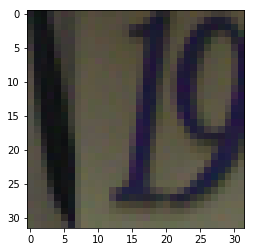

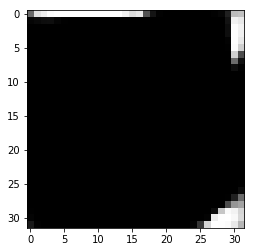

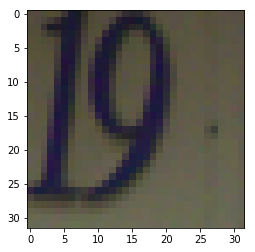

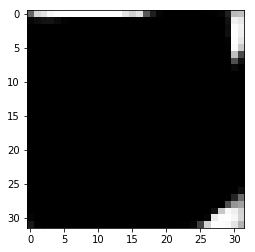

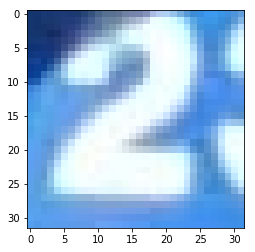

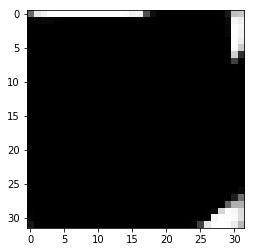

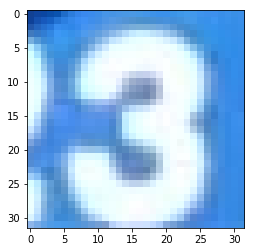

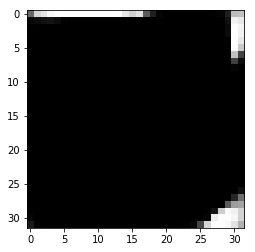

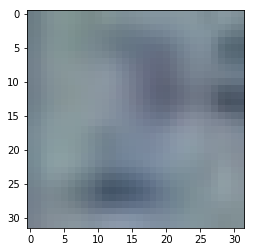

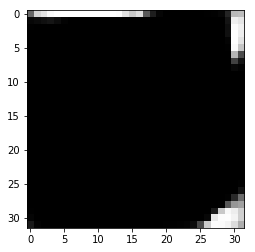

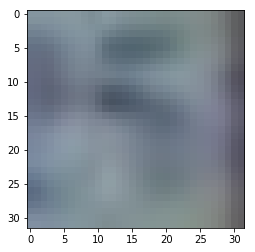

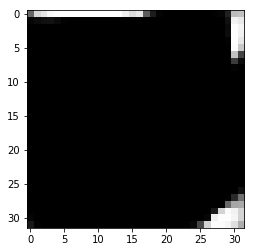

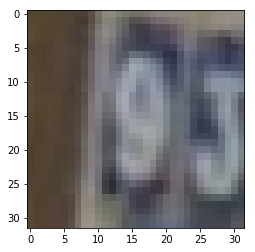

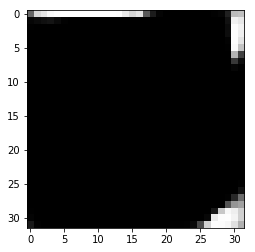

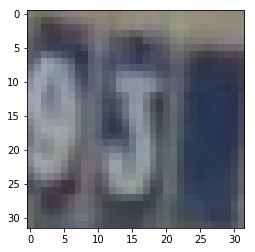

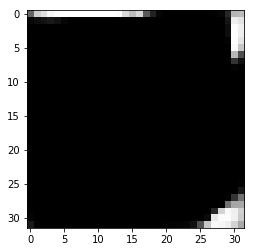

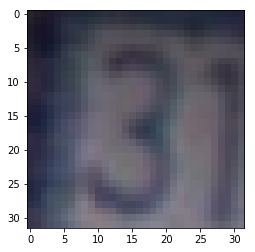

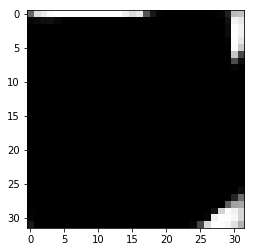

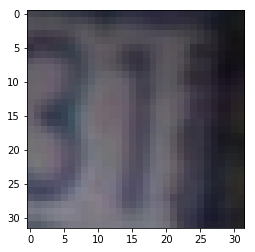

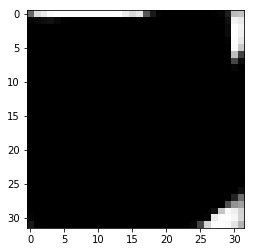

In [32]:
g_images = G.predict(svhn_test_X[:10])
for i in range(10):
    plt.figure()
    plt.imshow(svhn_train_X[i])
    plt.figure()
    plt.imshow(g_images[i][:, :, 0], cmap='gray')
D.predict(g_images)

In [19]:
D.evaluate(g_images, np.ones(10))

NameError: name 'g_images' is not defined